In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import math 
import collections

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')

/tmp/ipykernel_71148/1989132959.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [3]:
base_path ='../snap/vqa/vqa_lxr955_sports_datamaps_outliers/'

df_log_probabilities = pd.read_csv(base_path + 'log_probabilities.csv', sep=',', header=None)
df_log_probabilities = df_log_probabilities.T.fillna(0)[:-1]

df_log_probabilities_sigmoid = pd.read_csv(base_path + 'log_probabilities_sigmoid.csv', sep=',', header=None)
df_log_probabilities_sigmoid = df_log_probabilities_sigmoid.T.fillna(0)[:-1]


df_correct_preds = pd.read_csv(base_path + 'correct_preds.csv', sep=',', header=None)
df_correct_preds = df_correct_preds.T.fillna(0)[:-1]
eps = 1e-3

In [4]:
ques_ids = pd.read_csv(base_path+'ques_ids.csv', sep=',', header=None)
img_ids = pd.read_csv(base_path+'img_ids.csv', sep=',', header=None)

img_ids_test = img_ids[:1].to_numpy()
img_ids_test2 = img_ids[1:2].to_numpy()
print(collections.Counter(np.squeeze(img_ids_test)) == collections.Counter(np.squeeze(img_ids_test2)))

ques_ids_test = ques_ids[:1].to_numpy()
ques_ids_test2 = ques_ids[1:2].to_numpy()
print(collections.Counter(np.squeeze(ques_ids_test)) == collections.Counter(np.squeeze(ques_ids_test2)))

True
True


In [5]:
def calc_confidence(probabilities):
    sum_rows = np.sum(probabilities, axis=1)
    return (sum_rows+eps)/probabilities.shape[1]

def calc_variance(probabilities, means):
    probs = probabilities.to_numpy()
    means = np.expand_dims(means, axis=1)
    square = (probs-means)**2
    sum_rows = np.sum(square, axis=1) # sum across epochs
    divide = sum_rows/probabilities.shape[1]
    variance = np.sqrt(divide.astype(float))
    return variance

def calc_correctness(df_correct_preds):
    return df_correct_preds.sum(axis=1) / df_correct_preds.shape[1]


In [6]:
confidence_score = calc_confidence(df_log_probabilities)
confidence_score_sigmoid = calc_confidence(df_log_probabilities_sigmoid)
variance_score = calc_variance(df_log_probabilities, confidence_score)
variance_score_sigmoid = calc_variance(df_log_probabilities_sigmoid, confidence_score_sigmoid)
correctness_score = calc_correctness(df_correct_preds)

In [7]:
d = {"confidence": confidence_score, "variability": variance_score, "correctness":correctness_score}
df = pd.DataFrame(d)

d_sigmoid = {"confidence": confidence_score_sigmoid, "variability": variance_score_sigmoid, "correctness":correctness_score}
df_sigmoid = pd.DataFrame(d_sigmoid)

findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Georgia'] not found. Falling back to DejaVu Sans.


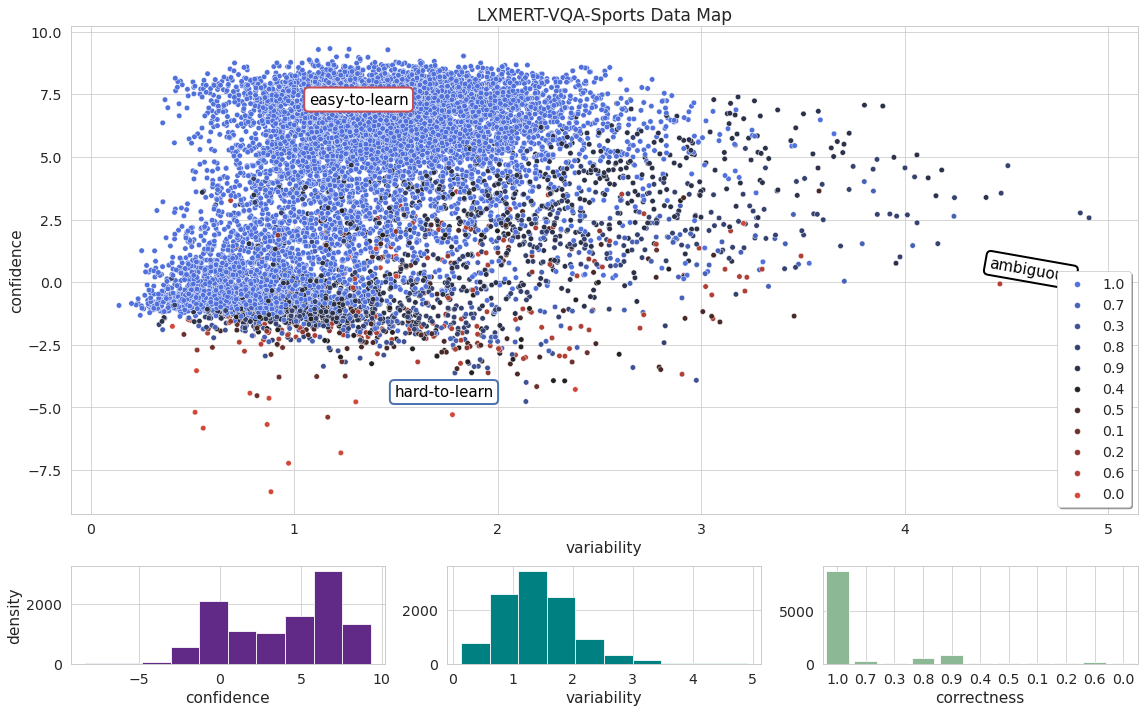

In [8]:
def scatter_it(dataframe, hue_metric ='correct.', title='', model='LXMERT', show_hist=False):
    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
    
    # Normalize correctness to a value between 0 and 1.
    dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
    dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]
    
    main_metric = 'variability'
    other_metric = 'confidence'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
    else:
        fig = plt.figure(figsize=(16, 10), )
        gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])
    
        ax0 = fig.add_subplot(gs[0, :])
    
    
    ### Make the scatterplot.
    
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30)
    
    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    an1 = ax0.annotate("ambiguous", xy=(0.9, 0.5), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", rotation=350, bbox=bb('black'))
    an2 = ax0.annotate("easy-to-learn", xy=(0.27, 0.85), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('r'))
    an3 = ax0.annotate("hard-to-learn", xy=(0.35, 0.25), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('b'))
    
    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0.5), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')
    
    if show_hist:
        plot.set_title(f"{model}-{title} Data Map", fontsize=17)
        
        # Make the histograms.
        ax1 = fig.add_subplot(gs[1, 0])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[1, 2])

        plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')

        plot2 = sns.countplot(x="correct.", data=dataframe, color='#86bf91', ax=ax3)
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2.set_title('')
        plot2.set_xlabel('correctness')
        plot2.set_ylabel('')

    fig.tight_layout()
    #filename = f'figures/{title}_{model}.pdf' if show_hist else f'figures/compact_{title}_{model}.pdf'
    #fig.savefig(filename, dpi=300)

scatter_it(df, title='VQA-Sports', show_hist=True)

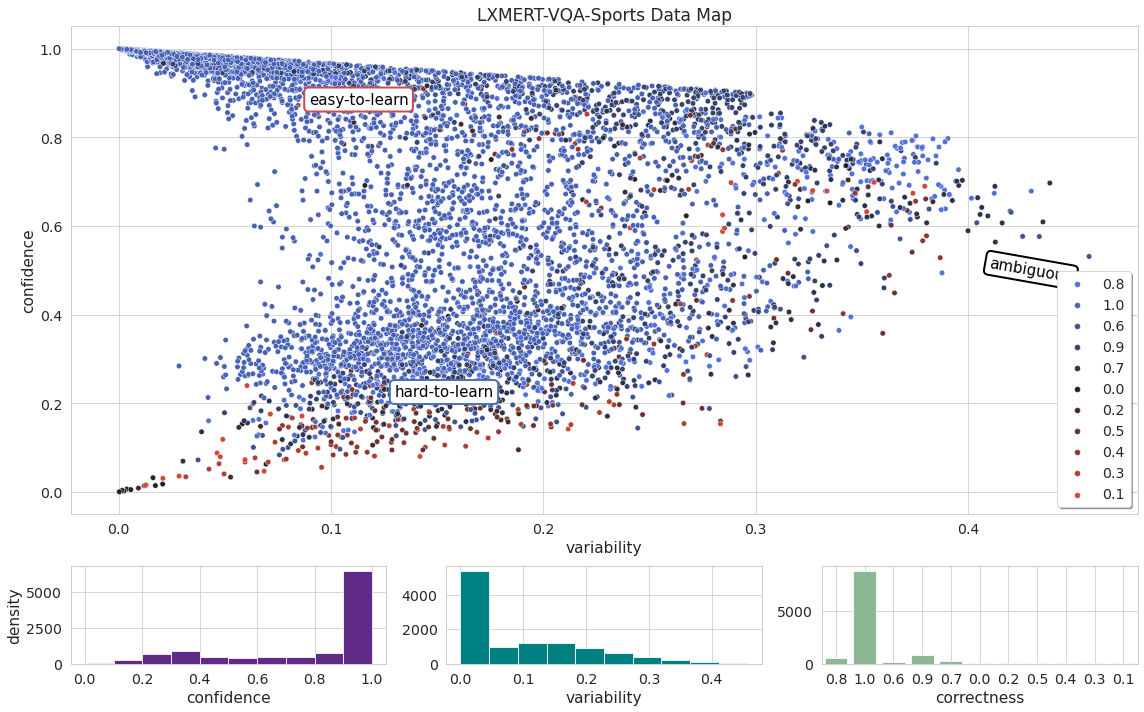

In [9]:
scatter_it(df_sigmoid, title='VQA-Sports', show_hist=True)

# Outlier Investigation

In [51]:
hard_to_learn_outliers_sigmoid = df_sigmoid.loc[(df_sigmoid['confidence'] < 0.2) & (df_sigmoid['variability'] < 0.3)]
easy_to_learn = df_sigmoid.loc[(df_sigmoid['confidence'] > 0.8) & (df_sigmoid['variability'] < 0.2)]
ambiguous = df_sigmoid.loc[(df_sigmoid['confidence'] > 0.6) & (df_sigmoid['variability'] > 0.4)]
# img_ids_test

outliers_indices = hard_to_learn_outliers_sigmoid.index
easy_to_learn_indices = easy_to_learn.index
ambiguous_indices = ambiguous.index

In [52]:
questions_sent = open(base_path+'questions_sent.txt', "r")
gt_answers = open(base_path+"ground_truth_answers.txt", "r")
preds_answers = open(base_path+"predicted_answers.txt", "r")

questions_sent_list = questions_sent.readlines()
gt_answers_list = gt_answers.readlines()
preds_answers_list = preds_answers.readlines()

def datamap_regions(questions, gt, preds, imgs, instance_indices, num=5):
    ids = []
    for i in instance_indices[:num]:
        print("Question: ", questions[i].strip())
        print("Ground Truth: ", gt[i].strip())
        print("Preds: ", preds[i].strip())
        print("Image_id: ", imgs[i])
        ids.append(int(imgs[i][-6:]))
    return ids

img_ids = np.squeeze(img_ids_test)
outlier_img_ids = datamap_regions(questions_sent_list, gt_answers_list, preds_answers_list, img_ids, outliers_indices)
easy_img_ids = datamap_regions(questions_sent_list, gt_answers_list, preds_answers_list, img_ids, easy_to_learn_indices)
ambiguous_img_ids = datamap_regions(questions_sent_list, gt_answers_list, preds_answers_list, img_ids, ambiguous_indices)


Question:  What sport is this?
Ground Truth:  volleyball
Preds:  soccer
Image_id:   COCO_train2014_000000306128
Question:  What is the person doing?
Ground Truth:  skiing
Preds:  skiing
Image_id:   COCO_train2014_000000095159
Question:  What game are they playing?
Ground Truth:  football
Preds:  tennis
Image_id:   COCO_train2014_000000265274
Question:  What is she doing?
Ground Truth:  softball
Preds:  baseball
Image_id:   COCO_train2014_000000415918
Question:  What color are their shirts?
Ground Truth:  tennis
Preds:  baseball
Image_id:   COCO_train2014_000000398704
Question:  What is the person doing?
Ground Truth:  skiing
Preds:  skiing
Image_id:  COCO_train2014_000000262146
Question:  What is this person doing?
Ground Truth:  skiing
Preds:  skiing
Image_id:   COCO_train2014_000000393230
Question:  What is the man doing?
Ground Truth:  skiing
Preds:  skiing
Image_id:   COCO_train2014_000000393230
Question:  What sport is this person playing?
Ground Truth:  baseball
Preds:  baseball


In [54]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
    "coco-2014",
    split="train",
    image_ids=ambiguous_img_ids
)



Found annotations at '/home/jaspreet/fiftyone/coco-2014/raw/instances_train2014.json'
 100% |██████████████████████| 5/5 [575.3ms elapsed, 0s remaining, 8.8 images/s]   
Writing annotations for 5 downloaded samples to '/home/jaspreet/fiftyone/coco-2014/train/labels.json'
Dataset info written to '/home/jaspreet/fiftyone/coco-2014/info.json'
Loading existing dataset 'coco-2014-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


# Training Stats


Text(23.700000000000003, 0.5, 'Correct Preds')

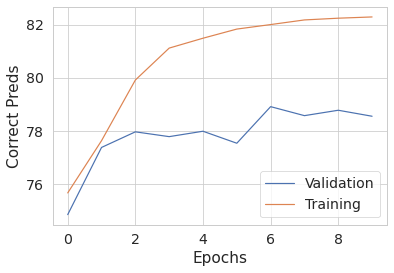

In [9]:
valid_scores = [0.7484162895927611, 0.7737556561085984, 0.779638009049775, 0.7778280542986434, 0.7798642533936664, 0.7753393665158382, 0.7891402714932139, 0.7857466063348428, 0.7877828054298656, 0.7855203619909514]
train_scores = [75.66013313609702, 77.63036242603762, 79.91771449704315, 81.12241124260518, 81.49500739645134, 81.83986686390689, 82.00998520710213, 82.18472633136254, 82.25036982248672, 82.29752218935066]
valid_scores = [i*100 for i in valid_scores]

xs_valid = [i for i in range(len(valid_scores))]
xs_train = [i for i in range(len(train_scores))]
plt.plot(xs_valid, valid_scores, label="Validation")
#plt.title("Validation")
plt.savefig(base_path+'/training.png')

plt.plot(xs_train, train_scores, label="Training")
#plt.title("Training")
plt.savefig(base_path+'/validation.png')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Correct Preds")